# Tutorial: Plot Galaxy Rotation Curve with SDSS-IV MaNGA data
In this tutorial, we use [SDSS-IV MaNGA](https://www.sdss.org/surveys/manga/) data to measure line of sight velocity and plot rotation curve of galaxy. 
## Required packages
* NUMPY: v1.14.3
* SCIPY: v1.1.0
* MATPLOTLIB: v2.2.2
* ASTROPY: v3.0.4
* PPXF: v6.7.1 (included in the distribution)

In [47]:
# import required packages
import numpy as np
from math import pi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from time import clock
from astropy.io import fits
import urllib.request
import os.path
from ppxf_wrap import ppxf_wrap

%matplotlib inline
# set inline figure size
plt.rcParams['figure.figsize'] = [9, 6]

---
## Download MaNGA Data & Catalog
Download MaNGA cube data and catalog from SDSS-IV DR14 Science Archieve Server (https://data.sdss.org/sas/dr14/)

* MaNGA data access <https://www.sdss.org/dr14/manga/manga-data/data-access/>

We use logarithmically-binned cube data

(-0.5, 561.5, 561.5, -0.5)

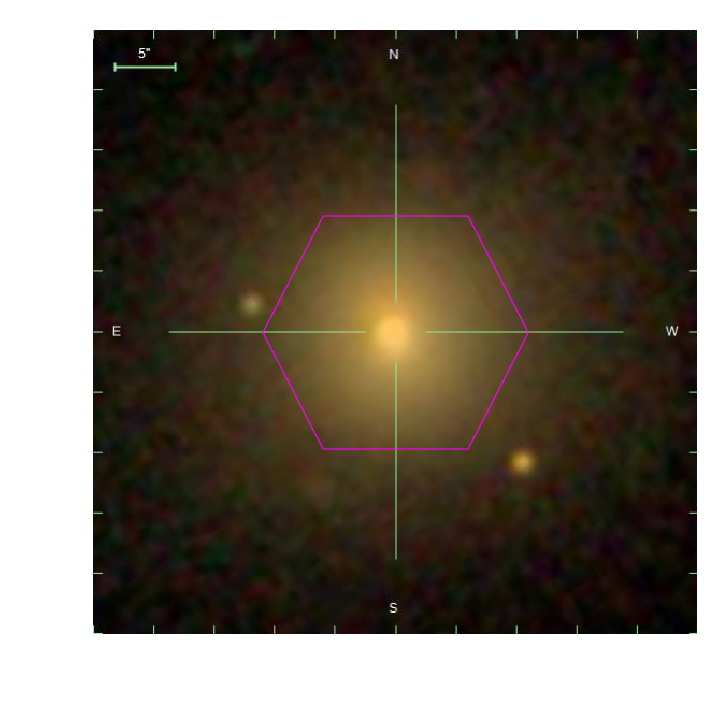

In [3]:
# plateifu of galaxy to download data
plateifu='8329-6103' # Spiral Galaxy
plateifu='8137-6103' # Elliptical Galaxy


plate, ifuname=plateifu.split('-')
cdir='./'  #current directory

# MaNGA cube file
cube_file='manga-'+plateifu+'-LOGCUBE.fits.gz'   # file to de downloaded

# download MaNGA cube file if not exist.
if not os.path.isfile(cdir+cube_file):
    sas_url="https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/"
    print("Start downloading "+cube_file+" from SDSS server. This may take several minutes.")
    urllib.request.urlretrieve(sas_url+plate+'/stack/'+cube_file, cdir+cube_file)
    print('Downloaded complete')


# MaNGA Catalog file (DR14)
drpall_file="drpall-v2_1_2.fits"

# download drpall file if not exist.
if not os.path.isfile(cdir+drpall_file):
    sas_url="https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/"
    print("Start downloading "+drpall_file+" from SDSS server. This may take several seconds.")
    urllib.request.urlretrieve(sas_url+"drpall-v2_1_2.fits", cdir+drpall_file)    
    print('Downloaded complete')
    
image_file=plateifu+'.png'
if not os.path.isfile(cdir+image_file):
    sas_url="https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/"
    print("Start downloading "+image_file+" from SDSS server. This may take several seconds.")
    urllib.request.urlretrieve(sas_url+plate+'/stack/images/'+ifuname+'.png', cdir+image_file)
    print('Downloaded complete')
    
# Show MaNGA galaxy image
fig=plt.figure(figsize=(4,4), dpi=200)
plt.imshow(mpimg.imread(cdir+image_file),aspect='equal')
plt.axis('off')

---
## Read galaxy information
In this tutorial, we need information of galaxy on
* Redshift(z)
* B/A ratio (inclination)
* Position Angle (PA)

MaNGA catalog file (drpall-v2_1_2.fits) contains above information for each galaxy.

In [4]:
drpall=fits.open(cdir+drpall_file)
tbdata=drpall[1].data
idx=np.where(tbdata['plateifu'] == plateifu)
objra=tbdata['objra'][idx][0]
objdec=tbdata['objdec'][idx][0]
nsa_z=tbdata['nsa_z'][idx][0]
nsa_elpetro_phi=tbdata['nsa_elpetro_phi'][idx][0]
nsa_elpetro_ba=tbdata['nsa_elpetro_ba'][idx][0]

print("Galaxy: ",plateifu)
print("RA, DEC:", objra, ',',objdec)
print("Redshift: ",nsa_z)
print("Position angle: ", nsa_elpetro_phi)
print("b/a ratio: ", nsa_elpetro_ba)
print('More info: http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra=%0.6f&dec=%0.6f&scale=0.2' % (objra, objdec))

# print(tbdata.columns.names)

Galaxy:  8137-6103
RA, DEC: 116.782606045 , 43.3140748538
Redshift:  0.0416588
Position angle:  3.76447
b/a ratio:  0.927868
More info: http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra=116.782606&dec=43.314075&scale=0.2


---
## Read galaxy cube data
Read and explore MaNGA Cube data.
In this tutorial, we are going to
- Plot galaxy spectrum at particular spaxel
- Plot galaxy intensity map

In [5]:
# Open and read flux, inverse variance, and mask cube.
cube = fits.open(cdir+cube_file)
flux=np.transpose(cube['FLUX'].data, axes=(2, 1, 0))
ivar=np.transpose(cube['IVAR'].data, axes=(2, 1, 0))
mask = np.transpose(cube['MASK'].data, axes=(2, 1, 0))
wave = cube['WAVE'].data
specres = cube['SPECRES'].data

flux_header = cube['FLUX'].header

### Plot galaxy spectrum
* Plot galaxy spectrum at the galaxy center.
* User can plot other part by changing x_plot and y_plot

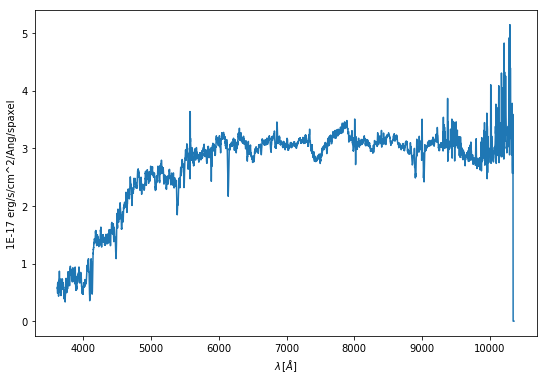

Cube 2D size:  54 by 54


In [48]:
#plot manga spectrum at the center
x_center = np.int(flux_header['CRPIX1']) - 1
y_center = np.int(flux_header['CRPIX2']) - 1

x_plot=x_center
y_plot=y_center

# User can plot other part of the galaxy
#x_plot=28
#y_plot=35

plt.plot(wave, flux[x_plot, y_plot])
plt.xlabel('$\lambda \, [\AA]$')
plt.ylabel(flux_header['BUNIT'])
plt.show()

print('Cube 2D size: ', flux.shape[0], 'by', flux.shape[1])

### Plot galaxy intensity map around Halpha
* Integrate spectrum flux around H alpha (6563 Angstrom) line. 
    * restframe 6550 to 6680 Angstrom
* Plot intensity map

Text(0,0.5,'arcsec')

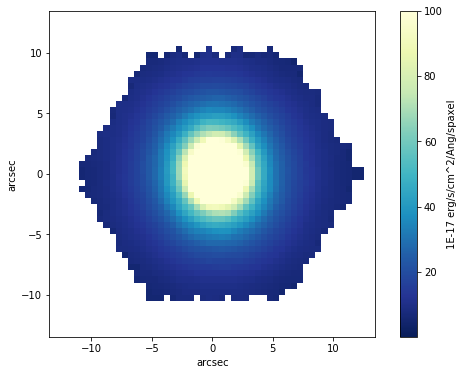

In [49]:
# process flux data 
do_not_use = (mask & 2**10) != 0
flux_m = np.ma.array(flux, mask=do_not_use)
ivar_m = np.ma.array(ivar, mask=do_not_use)

min_wave=6550
max_wave=6680
redshift = nsa_z
ind_wave = np.where((wave / (1 + redshift) > min_wave) & (wave / (1 + redshift) < max_wave))[0]
halpha = flux_m[:, :, ind_wave].sum(axis=2) # integrate flux along wavelength vector
im = halpha.T #Transpose numpy array

# Convert from array indices to arcsec relative to IFU center
dx = flux_header['CD1_1'] * 3600.  # deg to arcsec
dy = flux_header['CD2_2'] * 3600.  # deg to arcsec
x_extent = (np.array([0., im.shape[0]]) - (im.shape[0] - x_center)) * dx * (-1)
y_extent = (np.array([0., im.shape[1]]) - (im.shape[1] - y_center)) * dy
extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]

plt.imshow(im, extent=extent, cmap=cm.YlGnBu_r, vmin=0.1, vmax=100, origin='lower', interpolation='none')
plt.colorbar(label=flux_header['BUNIT'])
plt.xlabel('arcsec')
plt.ylabel('arcsec')

---
## Extract galaxy kinematics
* We use Penalized Pixel-Fitting method (pPXF) developed by Michele Cappellari to extract stellar kinematics of galaxy. 
    * http://www-astro.physics.ox.ac.uk/~mxc/software/#ppxf
    * pPXF(v6.7.1) in Python is included in this tutorial package. (ppxf.py and ppxf_util.py)
* pPXF fits template spectrum to the given galaxy spectrum to fit the galaxy kinematics.
* Four galaxy templates from MILES library is used in this tutorial.
    * Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/.
    * Metalicity (log(Z/Z_solar)=0), age: 1 Gyr, 2 Gyr, 8 Gyr, and 10 Gyr
        * Mun1.30Zp0.00T01.0000_iPp0.00_baseFe_linear_FWHM_2.51.fits
        * Mun1.30Zp0.00T07.9433_iPp0.00_baseFe_linear_FWHM_2.51.fits
        * Mun1.30Zp0.00T01.9953_iPp0.00_baseFe_linear_FWHM_2.51.fits
        * Mun1.30Zp0.00T10.0000_iPp0.00_baseFe_linear_FWHM_2.51.fits

* The warpper of pPXF is written separatly in ppxf_wrap.py.

### Measure line of sight velocity using ppxf_wrap
* To measure velocity in your own machine, set run_vel_measure = True
* ppxf_wrap measures velocity at each spaxel, one by one.
* Result will be saved in FITS format.

 i  j   Velocity Dispersion  Chi2    t


/home/hchung/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/hchung/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


20 06    125.702    167.738  0.78  0.5
21 06    156.467    174.731  1.06  0.3
22 06    131.798    164.187  0.72  0.8
25 06    140.571    184.982  0.84  1.5
26 06    150.799    195.440  1.07  0.4
27 06    103.970    154.282  0.63  0.8
30 06     54.168    157.594  0.52  2.0
31 06    150.799    182.874  1.07  0.5
32 06    115.882    193.961  0.68  1.0
36 06    163.712    198.467  0.86  0.3
37 06    118.449    130.363  0.71  1.1
17 07    121.265    208.276  1.03  0.5
18 07    114.680    223.875  0.99  0.5
19 07    123.417    221.398  0.97  0.4
20 07    141.363    195.157  0.97  0.4
21 07    155.718    175.182  1.04  0.5
22 07    163.916    177.602  1.11  0.3
23 07    168.396    185.845  1.08  0.4
24 07    168.512    194.612  1.04  0.5
25 07    153.370    191.386  0.97  1.2
26 07    153.452    197.441  1.08  0.5
27 07    128.573    187.067  0.90  1.0
28 07    144.658    208.074  0.96  0.4
29 07    155.969    211.459  0.94  0.4
30 07    126.715    168.046  0.85  0.7
31 07    150.027    180.3

26 14    185.718    190.301  1.68  0.9
27 14    185.708    187.567  1.73  1.2
28 14    188.447    191.729  1.79  0.5
29 14    187.296    193.758  1.79  0.9
30 14    182.074    191.174  1.75  1.1
31 14    178.281    190.384  1.68  1.2
32 14    178.343    188.978  1.84  0.6
33 14    180.382    186.022  1.76  0.8
34 14    177.706    185.897  1.72  1.5
35 14    171.809    183.712  1.73  1.3
36 14    168.213    185.236  1.44  0.6
37 14    161.702    189.217  1.22  0.7
38 14    158.202    194.433  1.05  0.4
39 14    159.806    197.164  1.04  1.0
40 14    164.216    193.598  1.14  0.5
41 14    171.394    192.436  1.19  0.6
42 14    167.452    191.198  1.16  1.3
43 14    154.588    190.750  1.21  0.7
44 14     48.160    163.757  0.58  1.1
11 15    125.175    166.915  1.05  0.6
12 15    128.151    174.346  1.14  0.6
13 15    130.542    179.940  1.11  0.8
14 15    134.409    192.958  1.18  0.7
15 15    136.165    206.583  1.17  1.3
16 15    135.416    208.204  1.12  0.7
17 15    138.191    204.6

23 20    173.089    221.252  1.80  1.1
24 20    180.321    218.374  2.23  0.5
25 20    189.639    217.011  2.30  0.5
26 20    194.036    221.091  2.51  1.1
27 20    189.392    219.579  2.84  0.7
28 20    182.896    215.592  2.40  0.7
29 20    179.938    217.426  2.92  0.4
30 20    177.066    215.855  1.96  0.6
31 20    178.554    215.167  2.03  0.5
32 20    175.086    215.661  1.67  0.4
33 20    171.272    219.497  1.77  0.9
34 20    165.363    223.933  1.85  0.7
35 20    158.051    220.133  1.46  1.0
36 20    153.897    218.143  1.40  0.5
37 20    143.506    214.116  1.39  0.5
38 20    137.389    212.588  1.49  0.4
39 20    133.511    211.852  1.44  0.8
40 20    131.089    204.659  1.34  0.5
41 20    128.366    200.042  1.18  0.7
42 20    125.821    192.560  1.16  0.3
43 20    123.313    188.343  1.15  0.4
44 20    112.718    184.585  1.14  0.5
45 20    101.233    178.203  1.19  0.5
46 20     92.325    170.589  1.10  0.7
08 21    110.619    240.048  1.01  0.3
09 21    109.818    231.4

24 25    141.417    273.283 16.26  0.9
25 25    141.485    275.263 22.71  1.0
26 25    138.586    270.876 27.22  0.4
27 25    136.165    270.765 26.84  0.4
28 25    135.945    272.522 23.16  0.3
29 25    136.929    268.585 20.97  0.4
30 25    136.324    253.716 16.43  0.4
31 25    136.132    247.706  9.39  0.6
32 25    135.106    242.295  5.71  0.6
33 25    135.697    242.696  4.13  0.5
34 25    127.955    226.174  3.19  0.7
35 25    114.439    216.386  1.74  0.6
36 25    109.516    214.215  1.56  0.8
37 25    113.139    214.100  1.52  0.4
38 25    120.673    217.152  1.42  0.4
39 25    125.939    211.420  1.43  0.5
40 25    123.632    201.673  1.40  0.4
41 25    122.942    200.760  1.42  0.6
42 25    121.801    207.402  1.43  0.3
43 25    116.472    212.001  1.31  0.3
44 25    109.163    214.755  1.16  0.7
45 25    106.718    214.300  1.10  0.3
46 25    104.765    220.486  1.11  0.4
47 25     96.646    217.283  1.17  0.4
48 25     75.825    198.321  1.19  0.3
49 25     42.658    151.0

13 30    105.401    200.231  1.18  0.5
14 30     98.613    193.773  1.36  0.3
15 30     88.706    191.003  1.41  0.4
16 30     83.602    195.312  1.36  0.6
17 30     84.477    207.881  1.55  0.4
18 30     87.462    222.453  1.67  0.5
19 30     88.971    231.070  2.74  0.4
20 30     86.019    235.150  3.86  0.3
21 30     80.989    239.964  3.77  0.5
22 30     84.983    250.811  9.35  0.3
23 30     86.378    261.275 11.94  0.5
24 30     88.997    267.094 24.05  0.5
25 30     91.425    272.715 32.32  0.3
26 30     91.213    276.453 28.83  0.6
27 30     93.331    278.326 40.65  0.5
28 30     95.790    288.903 33.68  0.6
29 30     95.069    282.099 33.86  0.3
30 30     92.052    269.511 17.38  0.3
31 30     88.637    252.462 10.24  0.4
32 30     86.510    243.308  5.99  0.3
33 30     88.843    242.847  5.95  0.4
34 30     91.168    234.345  4.21  0.5
35 30     95.953    224.987  2.31  0.4
36 30    105.528    223.360  1.95  0.6
37 30    107.132    213.128  1.46  0.4
38 30    111.018    214.0

27 35     31.778    231.625  4.18  0.5
28 35     31.956    226.674  4.03  0.3
29 35     36.357    224.683  3.17  0.5
30 35     44.873    229.479  2.95  0.3
31 35     51.411    227.886  2.35  0.4
32 35     55.724    221.823  2.41  0.6
33 35     56.382    211.122  1.90  0.6
34 35     61.367    210.446  1.73  0.7
35 35     70.778    214.955  1.56  0.4
36 35     83.136    218.897  1.36  0.4
37 35     94.205    217.886  1.43  0.4
38 35    103.441    216.820  1.44  0.5
39 35    106.233    215.458  1.35  0.4
40 35    107.759    210.481  1.27  0.7
41 35    108.044    209.687  1.15  0.5
42 35    100.207    201.569  1.16  0.6
43 35     86.324    192.059  1.18  0.4
44 35     81.307    189.597  1.09  0.4
45 35     80.085    181.642  1.07  0.6
46 35     89.538    176.300  1.10  0.5
10 36     72.033    129.700  0.78  0.5
11 36     95.933    183.326  1.41  0.5
12 36     87.316    186.249  1.44  0.3
13 36     82.325    190.482  1.36  0.6
14 36     77.560    192.641  1.40  0.5
15 36     75.988    194.5

32 41     46.022    194.694  1.46  0.3
33 41     50.793    201.104  1.42  0.4
34 41     55.088    205.867  1.40  1.0
35 41     61.762    204.922  1.42  0.2
36 41     68.892    208.329  1.36  0.3
37 41     71.699    209.966  1.49  0.3
38 41     75.535    215.993  1.52  0.5
39 41     71.071    208.816  1.44  0.5
40 41     70.372    204.944  1.52  0.3
41 41     68.801    200.564  1.32  0.4
42 41     32.015    182.710  1.07  0.9
13 42    106.539    205.880  1.43  0.4
14 42    108.429    200.711  1.33  0.5
15 42    105.877    193.879  1.24  0.7
16 42     93.491    183.611  1.30  0.8
17 42     81.135    181.347  1.37  0.6
18 42     65.936    185.391  1.27  0.9
19 42     61.242    194.622  1.40  0.3
20 42     58.703    200.589  1.40  0.4
21 42     49.647    193.291  1.37  0.4
22 42     43.347    190.359  1.45  0.2
23 42     32.890    182.743  1.27  0.5
24 42     28.828    186.743  1.31  0.5
25 42     25.276    192.789  1.22  0.3
26 42     22.989    192.136  1.15  0.3
27 42     26.578    195.4

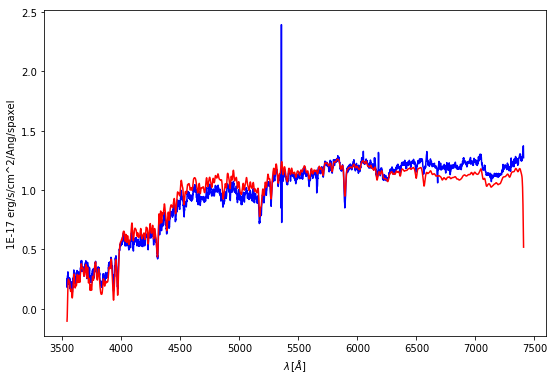

In [27]:
run_vel_measure=True

oname=cdir+'manga-'+plateifu+'-LOGCUBE_MAPS.fits'

# i, j index of spaxel to show comaparison result
check_i=27
check_j=27

if run_vel_measure:
    redshift=nsa_z
    ppxf_obj=ppxf_wrap(redshift, wave, specres)
    np.set_printoptions(threshold=np.nan)
    nx, ny, _ = flux.shape
    resarr=np.zeros((nx,ny))
    flagarr=np.zeros((nx,ny),dtype=np.int16) #define flag array
    t = clock()
    check_flag=False
    print("%2s %2s %10s %10s %5s %4s" % ('i', 'j', 'Velocity', 'Dispersion', 'Chi2', 't'))
    for j in range(nx):
        for i in range(ny):
            t = clock()
            if np.median(flux_m[i,j]) > 0:
                ppxf_obj.flux=flux_m[i,j]
                ppxf_obj.ivar=ivar_m[i,j]
                res=ppxf_obj.run()
                if not res:
                    continue
                resarr[i,j]=res.sol[0]
                flagarr[i,j]=1
                if i == check_i & j == check_j:
                    check_flag=True
                    sflux=ppxf_obj.fflux
                    sbestfit=res.bestfit
                print("%02d %02d %10.3f %10.3f %5.2f %4.1f" % (i, j, res.sol[0], res.sol[1], res.chi2, clock()-t))

    if check_flag:
        plt.plot(ppxf_obj.lam_gal, sflux, 'b-')
        plt.plot(ppxf_obj.lam_gal, sbestfit, 'r-')
        plt.xlabel('$\lambda \, [\AA]$')
        plt.ylabel(flux_header['BUNIT'])

    print('Save velocity measurement data in to FITS file: ', oname)
    hdu = fits.PrimaryHDU()
    hdu.writeto(oname, overwrite=True)

    fits.append(oname, resarr)
    fits.append(oname, flagarr.astype(np.int16))

    append_file=fits.open(oname, mode='update')

    hdr=append_file[1].header
    hdr.set('EXTNAME','STELLAR_VEL')
    hdr=append_file[2].header
    hdr['EXTNAME']='FLAG'

    append_file.close()

---
## Read and plot 2D velocity map
* Use pre-saved file when user skipped the previous part.

Text(0,0.5,'arcsec')

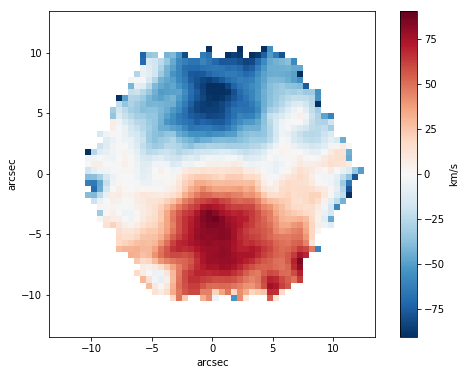

In [50]:
# read velocity map file
rfile='manga-'+plateifu+'-LOGCUBE_MAPS.fits'
if not os.path.isfile(cdir+rfile): # use pre-saved file if above one not exist.
    rfile='manga-'+plateifu+'-LOGCUBE_MAPS_SAVED.fits'
    
cube = fits.open(cdir+rfile)
velmap=cube['STELLAR_VEL'].data
nx, ny=np.int(flux_header['NAXIS1']) , np.int(flux_header['NAXIS2'])

# Plot 2D map
# Calculate velocity statistics (median and standard deviation) to re-scale map values for plot)
pvelmap=velmap.T
zero_idx=(pvelmap == 0)
pvelmap[zero_idx]=np.nan
finite_idx=np.isfinite(pvelmap)
medv, stdv, sigv=(np.median(pvelmap[finite_idx]), np.std(pvelmap[finite_idx]), 2)
pvelmap=pvelmap-medv

cmap= matplotlib.cm.RdBu_r
cmap.set_bad(color='white')
plt.imshow(pvelmap, extent=extent, cmap=cmap, vmin=(-stdv*sigv), vmax=stdv*sigv, origin='lower', interpolation='none')
plt.colorbar(label='km/s')
plt.xlabel('arcsec')
plt.ylabel('arcsec')

---
## Plot rotation curve
<img src="./gal_rot.png" alt="Drawing" style="width: 800px;"/>

* To plot rotation curve, $V(r)$, we need to perform coordinate transform of line of sight 2D velocity map into galactic coordinate system.
* A relation between $V_{LOS}$ and $V(r)$ is given as above.
* We will use known value of $V_{SYS}$, inclination angle $i$, and position angle $\phi_{0}$. All we need to do is calculating $r$ and $cos(\phi-\phi_{0})$
* How to calculate $r$ and $cos(\phi-\phi_{0})$ from $r'$ and $cos(\phi'-\phi'_{0})$ ?
    * $r\,cos(\phi-\phi_{0})=r' cos(\phi'-\phi'_{0})$ and $\phi_{0}=\phi'_{0}$
    * From tangent half-angle formula: $tan(\phi'/2)=y'/(x'+r')$
    * $tan(\phi-\phi_{0})=tan(\phi'-\phi_{0})\,cos\,i$
    * here $\phi_{0}=nsa\_elpetro\_phi+\pi/2$

(-11.79673904977932, 11.583130312575898)

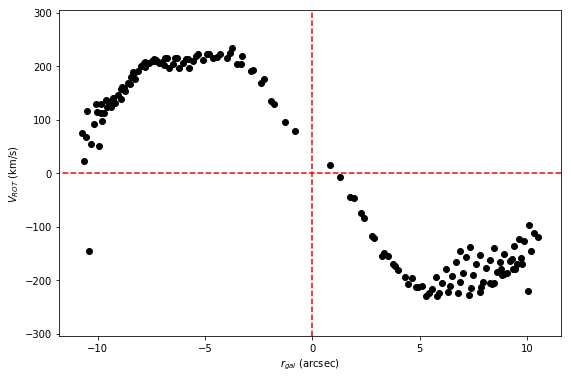

In [51]:
incl, phi0, cent_x, cent_y = np.arccos(nsa_elpetro_ba), (nsa_elpetro_phi+90)/180*pi, 0, 0

# below values from rotation model fitting (8329-6103)
# incl, phi0, cent_x, cent_y = 1.0487251 , 0.49254251+pi/2, 0.46911521, 0.45171812

# below values from rotation model fitting (8137-6103)
# incl, phi0, cent_x, cent_y = 0.81853998, 0.036205037+pi/2, 0.18230028, 0.32383320

aidx=np.arange(nx*ny)
ix=aidx % nx
iy=aidx // ny

x_obs=(ix-(nx/2-0.5))*0.5 # one pixel size correspond to 0.5 arcsec
y_obs=(iy-(ny/2-0.5))*0.5
r_obs=((x_obs-cent_x)**2+(y_obs-cent_y)**2)**0.5

tan_half_phi_obs=((y_obs-cent_y)/(x_obs-cent_x+r_obs))

phi_obs=2*np.arctan(tan_half_phi_obs)
tan_phi_gal=np.tan(phi_obs-phi0)/np.cos(incl)  # here phi_gal means phi_gal - PA_gal
cos_phi_gal=1/((1+tan_phi_gal**2)**0.5)

# calculate r_gal and v_rot
r_gal=r_obs*np.cos(phi_obs-phi0)/cos_phi_gal
v_rot=pvelmap.flatten()/cos_phi_gal/np.sin(incl)

# plot points only within +/- 20 degree from major axis
max_angle=20
major_idx=np.flatnonzero(np.abs((phi_obs-phi0)/pi*180 % 180 ) < max_angle)
r_gal=r_gal[major_idx]
v_rot=v_rot[major_idx]

ymax=np.max(v_rot[np.isfinite(np.abs(v_rot))])
xmax=np.max(r_gal[np.isfinite(np.abs(r_gal))])
ymul=1.3

plt.plot(r_gal, v_rot, 'ko')
xlim=plt.xlim()
plt.plot([-xmax, xmax], [0,0], 'r--')
plt.plot([0,0], [-ymax*ymul,ymax*ymul], 'r--')

plt.xlabel('$r_{gal}$ (arcsec)')
plt.ylabel('$V_{ROT}$ (km/s) ')
plt.ylim([-ymax*ymul,ymax*ymul])
plt.xlim(xlim)